# Initializing

In [1]:
!pip install torchinfo

from torchinfo import summary
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2 as cv
from scipy.linalg import hadamard
from scipy.ndimage import shift
import os
import torch


drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loaded Image

In [3]:
## Test Images (Unseen Images)
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Validation_512'
# folder_path = '/content/drive/My Drive/Colab Notebooks/Image/Training_Grey_128_Full'

test_image_array = []
#target_size = (128, 128)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        im = my_image.astype(np.float32)
        im = np.expand_dims(im, axis=-1)
        im = im / 255.0
        im = im[:,:,0]
        test_image_array.append(im)

# PSNR Function

In [4]:
def calculate_psnr(original, distorted):
  """
  Calculate PSNR (Peak Signal-to-Noise Ratio) between two images.

  Parameters:
      original (numpy.ndarray): The original image.
      distorted (numpy.ndarray): The distorted image (same shape as original).

  Returns:
      float: PSNR value in decibels (dB).
  """
  mse = np.mean((original - distorted) ** 2)
  if mse == 0:
      return float('inf')  # No difference, PSNR is infinite

  max_pixel = 1.0 if original.max() <= 1.0 else 255.0  # Choose based on normalization
  psnr = 10 * np.log10((max_pixel ** 2) / mse)
  return psnr

# Main

PSNR: 20.66601946520446 db


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

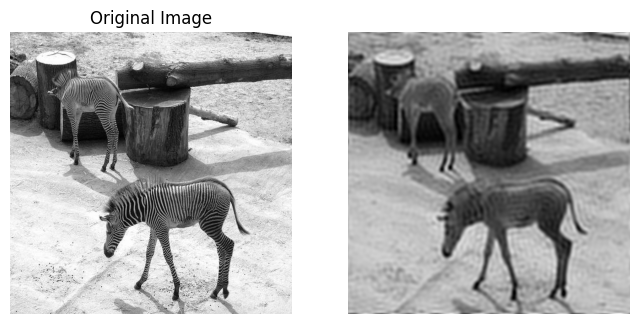

In [5]:
im = test_image_array[4]



mask_ratio = 0.1
bit_pair = np.random.choice([0, 1], size=2)

watermarking = CNNWatermarking(im, mask_ratio)
watermarked_block = watermarking.embedding(bit_pair)

print(f"PSNR: {calculate_psnr(im, watermarked_block)} db")

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(watermarked_block, cmap='gray')
plt.axis('off')
plt

Overall average coefficient (mean of all mask_ratio coefficients): 72.11 dB


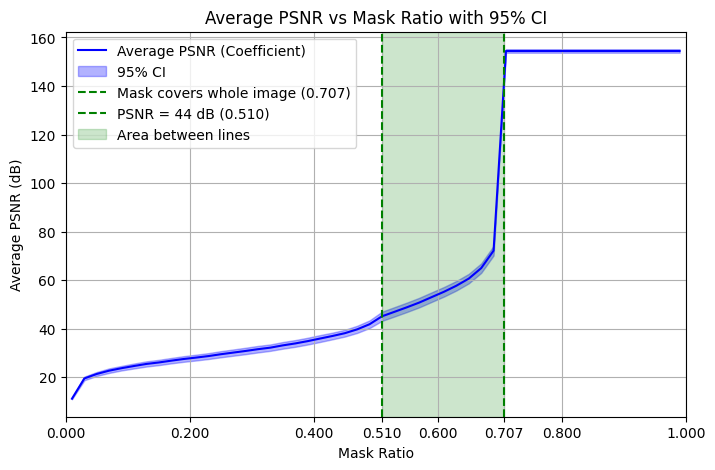

Overall average coefficient: 72.11 dB
Overall average coefficient as percentage of max PSNR: 46.70%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

mask_ratios = np.linspace(0.01, 0.99, 50)
average_psnrs = []
lower_ci = []
upper_ci = []

bit_pair = np.random.choice([0, 1], size=2)
n_images = 50

for mask_ratio in mask_ratios:
    psnr_list = []

    for im in test_image_array[:n_images]:
        watermarking = CNNWatermarking(im, mask_ratio)
        watermarked_block = watermarking.embedding(bit_pair)
        psnr = calculate_psnr(im, watermarked_block)
        psnr_list.append(psnr)

    # Coefficient value for this mask_ratio
    coeff = np.mean(psnr_list)
    std_psnr = np.std(psnr_list, ddof=1)

    # 95% confidence interval
    ci = stats.t.ppf(0.975, n_images-1) * (std_psnr / np.sqrt(n_images))

    average_psnrs.append(coeff)
    lower_ci.append(coeff - ci)
    upper_ci.append(coeff + ci)

average_psnrs = np.array(average_psnrs)
lower_ci = np.array(lower_ci)
upper_ci = np.array(upper_ci)

# Compute overall average coefficient across all mask_ratios
overall_average_coefficient = np.mean(average_psnrs)
print(f"Overall average coefficient (mean of all mask_ratio coefficients): {overall_average_coefficient:.2f} dB")

# Find mask_ratio where PSNR ≈ 44 dB
idx_44dB = np.argmin(np.abs(average_psnrs - 44))
mask_ratio_44dB = mask_ratios[idx_44dB]

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(mask_ratios, average_psnrs, color='blue', label='Average PSNR (Coefficient)')
plt.fill_between(mask_ratios, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')

# Vertical dashed red lines
plt.axvline(0.707, color='green', linestyle='--', label='Mask covers whole image (0.707)')
plt.axvline(mask_ratio_44dB, color='green', linestyle='--', label=f'PSNR = 44 dB ({mask_ratio_44dB:.3f})')

# Shade area between the two lines
x_min = min(0.707, mask_ratio_44dB)
x_max = max(0.707, mask_ratio_44dB)
plt.axvspan(x_min, x_max, color='green', alpha=0.2, label='Area between lines')

# Keep x-axis strictly between 0 and 1
plt.xlim(0, 1)

# Set x-axis ticks to include the two special mask_ratios
default_ticks = np.linspace(0, 1, 6)  # 0, 0.2, 0.4, 0.6, 0.8, 1
new_ticks = sorted(set(default_ticks.tolist() + [0.707, mask_ratio_44dB]))
plt.xticks(new_ticks)

plt.title("Average PSNR vs Mask Ratio with 95% CI")
plt.xlabel("Mask Ratio")
plt.ylabel("Average PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()

max_psnr = np.max(average_psnrs)
overall_average_coefficient = np.mean(average_psnrs)
overall_average_percentage = (overall_average_coefficient / max_psnr) * 100

print(f"Overall average coefficient: {overall_average_coefficient:.2f} dB")
print(f"Overall average coefficient as percentage of max PSNR: {overall_average_percentage:.2f}%")



In [8]:
for index in range(len(mask_ratios)):
  print(f"r = {mask_ratios[index]}   ,   PSNR = {average_psnrs[index]}")

# print(f"r = {mask_ratios[index]}   ,   PSNR = {average_psnrs[index]}")

r = 0.01   ,   PSNR = 11.147382142244535
r = 0.03   ,   PSNR = 19.501676859036632
r = 0.05   ,   PSNR = 21.341804694376204
r = 0.06999999999999999   ,   PSNR = 22.70285217666341
r = 0.09   ,   PSNR = 23.722092721385515
r = 0.11   ,   PSNR = 24.617837580216232
r = 0.13   ,   PSNR = 25.466217211332864
r = 0.15000000000000002   ,   PSNR = 26.071047304013003
r = 0.17   ,   PSNR = 26.813464698441006
r = 0.19   ,   PSNR = 27.500787729387
r = 0.21000000000000002   ,   PSNR = 28.082351216471984
r = 0.23   ,   PSNR = 28.7065897963002
r = 0.25   ,   PSNR = 29.467136634851883
r = 0.27   ,   PSNR = 30.140952502170776
r = 0.29000000000000004   ,   PSNR = 30.81942688906741
r = 0.31   ,   PSNR = 31.550925392905157
r = 0.33   ,   PSNR = 32.1825836783188
r = 0.35000000000000003   ,   PSNR = 33.12023782961762
r = 0.37   ,   PSNR = 33.91169847667322
r = 0.39   ,   PSNR = 34.859231545357495
r = 0.41000000000000003   ,   PSNR = 35.92651261953425
r = 0.43   ,   PSNR = 36.982956507234384
r = 0.45   ,   PSNR 

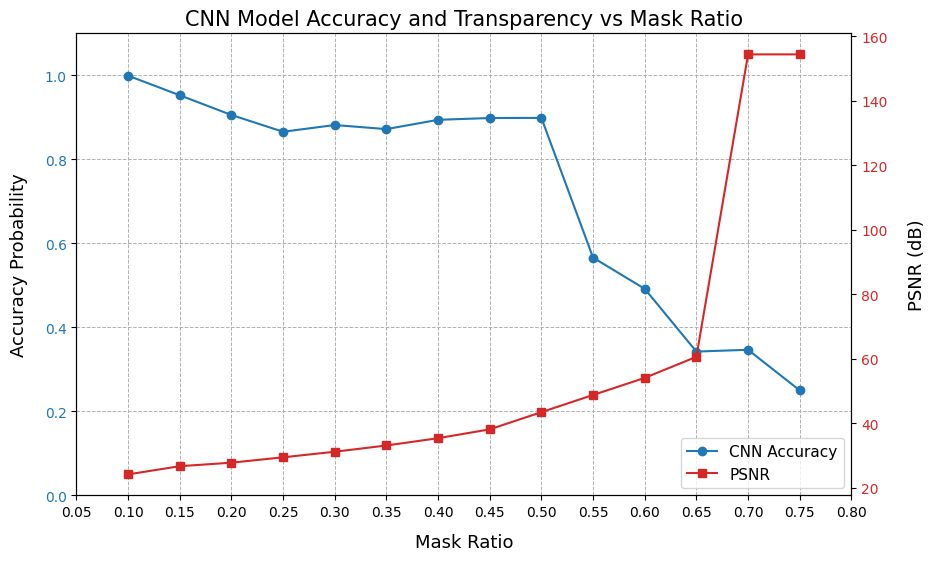

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Data
mask_ratio = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
f1_score = [0.9994, 0.9527, 0.9058, 0.8658, 0.8818, 0.8721, 0.8942, 0.8985, 0.8988, 0.5661, 0.4918, 0.3424, 0.3467, 0.25]
psnr = [24.16, 26.7, 27.79, 29.46, 31.185, 33.12, 35.385, 38.13, 43.464, 48.79, 54.09, 60.63, 154.42, 154.42]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot F1 score
color = 'tab:blue'
ax1.set_xlabel('Mask Ratio', labelpad=10, fontsize=13)
ax1.set_ylabel('Accuracy Probability', labelpad=12, fontsize=13)  # move label a bit higher
ax1.plot(mask_ratio, f1_score, marker='o', color=color, label='CNN Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.1)  # F1 score range

# Create secondary axis for PSNR
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PSNR (dB)', labelpad=15, fontsize=13)  # move label a bit higher
ax2.plot(mask_ratio, psnr, marker='s', color=color, label='PSNR')
ax2.tick_params(axis='y', labelcolor=color)

# Activate both X and Y grids on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Set X-axis ticks with 0.05 steps
ax1.set_xticks(np.arange(0.05, 0.85, 0.05))  # include 0.8 for clarity

# Set X-axis limits from 0.05 to 0.8
ax1.set_xlim(0.05, 0.8)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right', fontsize=11)

# Title
plt.title('CNN Model Accuracy and Transparency vs Mask Ratio', fontsize=15)

# Show plot
plt.show()


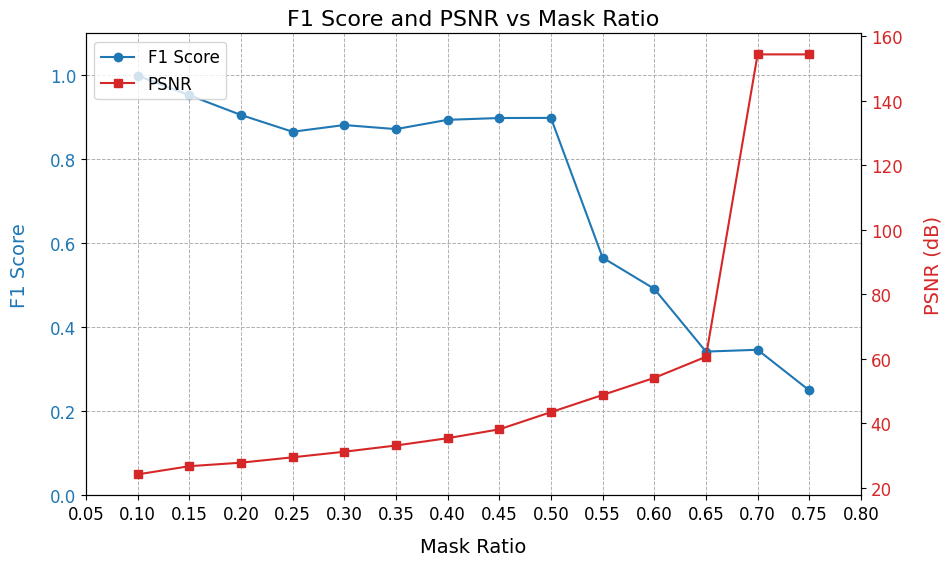

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data
mask_ratio = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
f1_score = [0.9994, 0.9527, 0.9058, 0.8658, 0.8818, 0.8721, 0.8942, 0.8985, 0.8988, 0.5661, 0.4918, 0.3424, 0.3467, 0.25]
psnr = [24.16, 26.7, 27.79, 29.46, 31.185, 33.12, 35.385, 38.13, 43.464, 48.79, 54.09, 60.63, 154.42, 154.42]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot F1 score
color = 'tab:blue'
ax1.set_xlabel('Mask Ratio', labelpad=10, fontsize=14)
ax1.set_ylabel('F1 Score', color=color, labelpad=15, fontsize=14)  # fontsize changed
ax1.plot(mask_ratio, f1_score, marker='o', color=color, label='F1 Score')
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)  # Y-axis tick font size
ax1.tick_params(axis='x', labelsize=12)  # X-axis tick font size
ax1.set_ylim(0, 1.1)

# Create secondary axis for PSNR
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('PSNR (dB)', color=color, labelpad=15, fontsize=14)  # fontsize changed
ax2.plot(mask_ratio, psnr, marker='s', color=color, label='PSNR')
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

# Activate both X and Y grids
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Set X-axis ticks with 0.05 steps
ax1.set_xticks(np.arange(0.05, 0.85, 0.05))
ax1.set_xlim(0.05, 0.8)

# Add legends with bigger font
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

# Title
plt.title('F1 Score and PSNR vs Mask Ratio', fontsize=16)

plt.show()


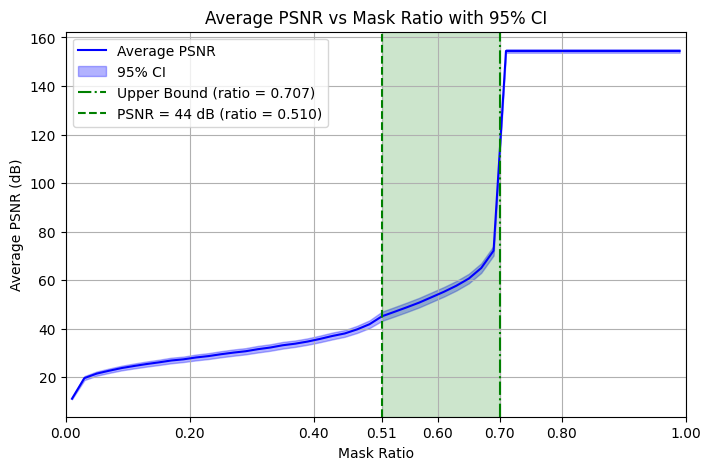

Overall average coefficient: 72.11 dB
Overall average coefficient as percentage of max PSNR: 46.70%


In [ ]:

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(mask_ratios, average_psnrs, color='blue', label='Average PSNR')
plt.fill_between(mask_ratios, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')

# Vertical dashed red lines
plt.axvline(0.7, color='green', linestyle='-.', label='Upper Bound (ratio = 0.707)')
plt.axvline(mask_ratio_44dB, color='green', linestyle='--', label=f'PSNR = 44 dB (ratio = {mask_ratio_44dB:.3f})')

# Shade area between the two lines
x_min = min(0.7, mask_ratio_44dB)
x_max = max(0.7, mask_ratio_44dB)
plt.axvspan(x_min, x_max, color='green', alpha=0.2)

# Keep x-axis strictly between 0 and 1
plt.xlim(0, 1)

# Set x-axis ticks to include the two special mask_ratios
default_ticks = np.linspace(0, 1, 6)  # 0, 0.2, 0.4, 0.6, 0.8, 1
new_ticks = sorted(set(default_ticks.tolist() + [0.7, mask_ratio_44dB]))
plt.xticks(new_ticks)

plt.title("Average PSNR vs Mask Ratio with 95% CI")
plt.xlabel("Mask Ratio")
plt.ylabel("Average PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()

max_psnr = np.max(average_psnrs)
overall_average_coefficient = np.mean(average_psnrs)
overall_average_percentage = (overall_average_coefficient / max_psnr) * 100

print(f"Overall average coefficient: {overall_average_coefficient:.2f} dB")
print(f"Overall average coefficient as percentage of max PSNR: {overall_average_percentage:.2f}%")




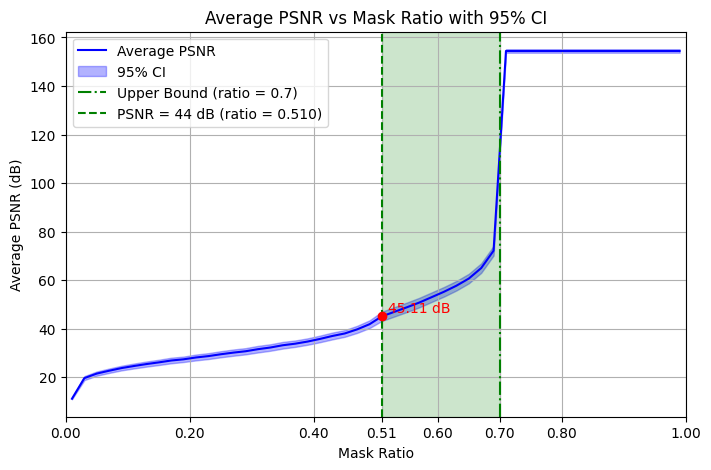

Overall average coefficient: 72.11 dB
Overall average coefficient as percentage of max PSNR: 46.70%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Assuming you already have these arrays from previous calculations ---
# mask_ratios, average_psnrs, lower_ci, upper_ci, mask_ratio_44dB

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(mask_ratios, average_psnrs, color='blue', label='Average PSNR')
plt.fill_between(mask_ratios, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')

# Vertical lines
plt.axvline(0.7, color='green', linestyle='-.', label='Upper Bound (ratio = 0.7)')
plt.axvline(mask_ratio_44dB, color='green', linestyle='--', label=f'PSNR = 44 dB (ratio = {mask_ratio_44dB:.3f})')

# Shade area between the two lines
x_min = min(0.7, mask_ratio_44dB)
x_max = max(0.7, mask_ratio_44dB)
plt.axvspan(x_min, x_max, color='green', alpha=0.2)

# Keep x-axis strictly between 0 and 1
plt.xlim(0, 1)

# Set x-axis ticks to include the two special mask_ratios
default_ticks = np.linspace(0, 1, 6)  # 0, 0.2, 0.4, 0.6, 0.8, 1
new_ticks = sorted(set(default_ticks.tolist() + [0.7, mask_ratio_44dB]))
plt.xticks(new_ticks)

# --- Mark PSNR at mask_ratio_44dB slightly above the curve ---
psnr_at_44dB = np.interp(mask_ratio_44dB, mask_ratios, average_psnrs)
offset = 0.5  # distance above the point
plt.scatter(mask_ratio_44dB, psnr_at_44dB, color='red', zorder=5)
plt.text(mask_ratio_44dB + 0.01, psnr_at_44dB + offset, f"{psnr_at_44dB:.2f} dB",
         color='red', va='bottom', ha='left')

plt.title("Average PSNR vs Mask Ratio with 95% CI")
plt.xlabel("Mask Ratio")
plt.ylabel("Average PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()

# --- Compute overall coefficient percentage ---
max_psnr = np.max(average_psnrs)
overall_average_coefficient = np.mean(average_psnrs)
overall_average_percentage = (overall_average_coefficient / max_psnr) * 100

print(f"Overall average coefficient: {overall_average_coefficient:.2f} dB")
print(f"Overall average coefficient as percentage of max PSNR: {overall_average_percentage:.2f}%")


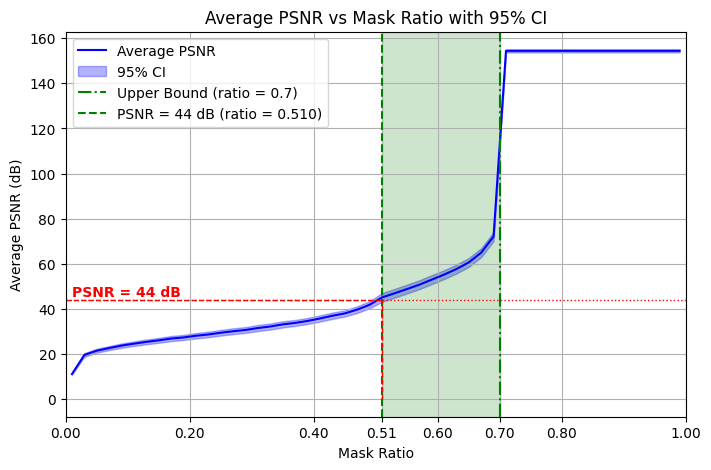

Overall average coefficient: 72.11 dB
Overall average coefficient as percentage of max PSNR: 46.70%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Assuming you already have these arrays from previous calculations ---
# mask_ratios, average_psnrs, lower_ci, upper_ci, mask_ratio_44dB

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(mask_ratios, average_psnrs, color='blue', label='Average PSNR')
plt.fill_between(mask_ratios, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')

# Vertical lines
plt.axvline(0.7, color='green', linestyle='-.', label='Upper Bound (ratio = 0.7)')
plt.axvline(mask_ratio_44dB, color='green', linestyle='--', label=f'PSNR = 44 dB (ratio = {mask_ratio_44dB:.3f})')

# Shade area between the two lines
x_min = min(0.7, mask_ratio_44dB)
x_max = max(0.7, mask_ratio_44dB)
plt.axvspan(x_min, x_max, color='green', alpha=0.2)

# Keep x-axis strictly between 0 and 1
plt.xlim(0, 1)

# Set x-axis ticks to include the two special mask_ratios
default_ticks = np.linspace(0, 1, 6)  # 0, 0.2, 0.4, 0.6, 0.8, 1
new_ticks = sorted(set(default_ticks.tolist() + [0.7, mask_ratio_44dB]))
plt.xticks(new_ticks)

# --- Draw dashed lines from axes to intersection at mask_ratio_44dB ---
plt.plot([0, mask_ratio_44dB], [44, 44], color='red', linestyle='--', linewidth=1)  # horizontal
plt.plot([mask_ratio_44dB, mask_ratio_44dB], [0, 44], color='red', linestyle='--', linewidth=1)  # vertical

# --- Draw horizontal line at PSNR = 44 dB across the diagram ---
plt.axhline(44, color='red', linestyle=':', linewidth=1)
plt.text(0.01, 44 + 0.2, "PSNR = 44 dB", color='red', va='bottom', ha='left', fontweight='bold')

plt.title("Average PSNR vs Mask Ratio with 95% CI")
plt.xlabel("Mask Ratio")
plt.ylabel("Average PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()

# --- Compute overall coefficient percentage ---
max_psnr = np.max(average_psnrs)
overall_average_coefficient = np.mean(average_psnrs)
overall_average_percentage = (overall_average_coefficient / max_psnr) * 100

print(f"Overall average coefficient: {overall_average_coefficient:.2f} dB")
print(f"Overall average coefficient as percentage of max PSNR: {overall_average_percentage:.2f}%")


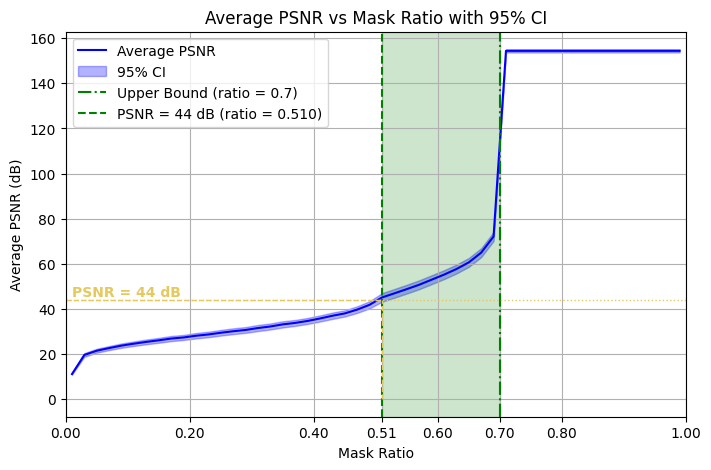

Overall average coefficient: 72.11 dB
Overall average coefficient as percentage of max PSNR: 46.70%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Assuming you already have these arrays from previous calculations ---
# mask_ratios, average_psnrs, lower_ci, upper_ci, mask_ratio_44dB

# Custom color for 44 dB reference
ref_color = "#E5C95F"

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(mask_ratios, average_psnrs, color='blue', label='Average PSNR')
plt.fill_between(mask_ratios, lower_ci, upper_ci, color='blue', alpha=0.3, label='95% CI')

# Vertical lines
plt.axvline(0.7, color='green', linestyle='-.', label='Upper Bound (ratio = 0.7)')
plt.axvline(mask_ratio_44dB, color='green', linestyle='--', label=f'PSNR = 44 dB (ratio = {mask_ratio_44dB:.3f})')

# Shade area between the two lines
x_min = min(0.7, mask_ratio_44dB)
x_max = max(0.7, mask_ratio_44dB)
plt.axvspan(x_min, x_max, color='green', alpha=0.2)

# Keep x-axis strictly between 0 and 1
plt.xlim(0, 1)

# Set x-axis ticks to include the two special mask_ratios
default_ticks = np.linspace(0, 1, 6)  # 0, 0.2, 0.4, 0.6, 0.8, 1
new_ticks = sorted(set(default_ticks.tolist() + [0.7, mask_ratio_44dB]))
plt.xticks(new_ticks)

# --- Draw dashed lines from axes to intersection at mask_ratio_44dB ---
plt.plot([0, mask_ratio_44dB], [44, 44], color=ref_color, linestyle='--', linewidth=1)  # horizontal
plt.plot([mask_ratio_44dB, mask_ratio_44dB], [0, 44], color=ref_color, linestyle='--', linewidth=1)  # vertical

# --- Draw horizontal line at PSNR = 44 dB across the diagram ---
plt.axhline(44, color=ref_color, linestyle=':', linewidth=1)
plt.text(0.01, 44 + 0.2, "PSNR = 44 dB", color=ref_color, va='bottom', ha='left', fontweight='bold')

plt.title("Average PSNR vs Mask Ratio with 95% CI")
plt.xlabel("Mask Ratio")
plt.ylabel("Average PSNR (dB)")
plt.grid(True)
plt.legend()
plt.show()

# --- Compute overall coefficient percentage ---
max_psnr = np.max(average_psnrs)
overall_average_coefficient = np.mean(average_psnrs)
overall_average_percentage = (overall_average_coefficient / max_psnr) * 100

print(f"Overall average coefficient: {overall_average_coefficient:.2f} dB")
print(f"Overall average coefficient as percentage of max PSNR: {overall_average_percentage:.2f}%")
